# Solving one electron problems with sturmian basis.
numpy (general operations), matplotlib (plotting), scipy (generalized eigenvalue problem), numba (faster calculations)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import njit, prange
from tqdm import tqdm
import math

# atoms definitions

EPSILON = 10e-13

ATOMS = {
    "Li": {
        "z": 3,
        "alpha_c": 0.1923,
        "rc": 0.61340824,
        "a1": 2.47718079,
        "a2": 1.84150932,
        "a3": -0.02169712,
        "a4": -0.11988362,
    },
    "Rb":
    {
        "z": 37,
        "alpha_c": 9.0760,
        "rc": 1.66242117,
        "a1": 3.69628474,
        "a2": 1.64915255,
        "a3": -9.86069196,
        "a4": 0.19579987,
    },
    "Cs":
    {
        "z": 55,
        "alpha_c": 15.6440,
        "rc": 1.92046930,
        "a1": 3.49546309,
        "a2": 1.47533800,
        "a3": -9.72143084,
        "a4": 0.02629242,
    },
}

In [6]:
def GLP(x, N, alpha):  # Generalized Laguerre polynomials
    L0 = np.ones_like(x)
    L1 = 1.0 + alpha - x

    if N == 0:
        Ln = L0
    if N == 1:
        Ln = L1

    for n in range(2, N + 1):
        Ln = (((2 * n - 1 + alpha - x)) * L1 - (n - 1 + alpha) * L0) / n
        L0, L1 = L1, Ln
    
    return Ln


def Skl(r, k, l, q):  # Sturmian
    # np.sqrt((factorial(k) / (2 * factorial(2 * l + 1 + k)))) before usage of log gamma function
    return (
        (np.sqrt(2)/2) *
        np.exp(
            (1 / 2) * (math.lgamma(k + 1) - math.lgamma(2 * l + 2 + k))
        )  # Using log gamma to avoid overflow
        * np.exp(-q * r)
        * ((2 * q * r) ** (l + 1))
        * GLP(2 * q * r, k, 2 * l + 1)
    )

def V1(r):
    return -1 / r


def Z(r, z, a1, a2, a3, a4):
    return 1 + (z - 1) * np.exp(-a1 * r) - r * (a3 + a4 * r) * np.exp(-a2 * r)

def V2(r, alpha_c, rc, a1, a2, a3, a4, z):
    return -(Z(r, z, a1, a2, a3, a4)) / r - (alpha_c / (2 * r**4)) * (1 - (np.exp(-((r / rc) ** 6))))

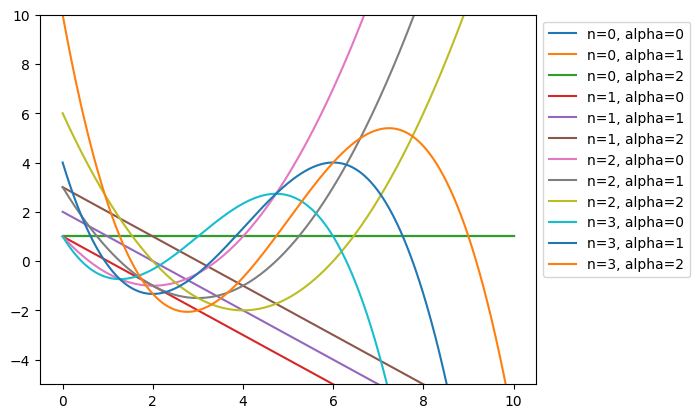

In [7]:
plt.close()

dr = 0.01
r = np.linspace(0.0, 10, 1000)
for i in range(0, 4):
    for j in range(0, 3):
        y = GLP(r, i, j)
        plt.plot(r, y, label=f"n={i}, alpha={j}")


plt.ylim(-5, 10)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.show()

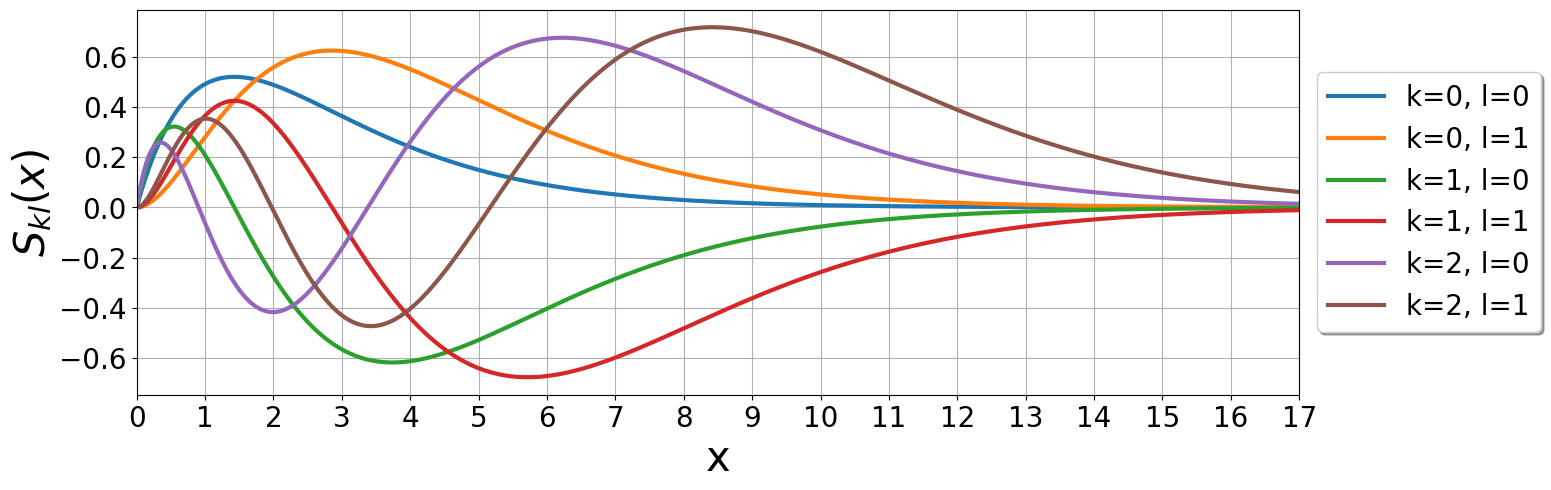

In [4]:
from tkinter import font

plt.close()
plt.figure(figsize=(15, 5))
q = 0.7
max_x = 17
x = np.linspace(0.01, max_x, 1000)

for k in range(0, 3):
    for l in range(0, 2):
        y = Skl(x, k, l, q)
        # ax[0].plot(x, np.abs(y)**2, label=f"k={k}, l={l}")
        plt.plot(x, y, label=f"k={k}, l={l}", linewidth=3)

plt.xticks(np.arange(0, 21, 1))
plt.xlim(0.0, max_x)

plt.xlabel("x", fontsize=30)
plt.ylabel(r"$S_{kl}(x)$", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.22, 0.5),
          ncol=1, fancybox=True, shadow=True, fontsize=20)
plt.show()

In [80]:
r_max = 15
q = 0.7
n = 2
l = 2

Nr = 10000

x = np.linspace(0, r_max, Nr)
y = Skl(x, n, l, q)

print(((y**2) * (r_max / Nr)).sum())

3.3980389541038236


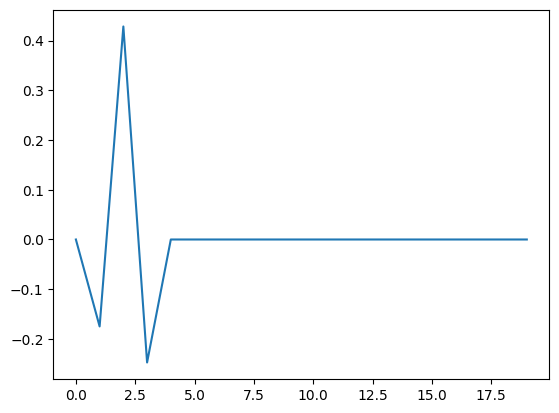

In [134]:
k1, k2 = 2, 1 # k1+1 i k1-1
l1, l2 = 0, 0
q = 0.7
N = 20

dr = 0.01

s = 0
r = np.linspace(0.0, 100, 2000)

s_list = np.zeros(N)

for i, k2 in enumerate(range(N)):
    s_list[i] = (Skl(r, k1, l1, q)*Skl(r, k2, l2, q)*dr).sum()

plt.plot(s_list)

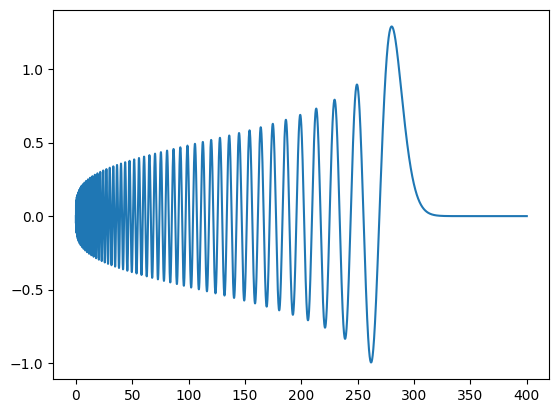

In [137]:
x = np.linspace(0, 400, 10000, dtype=np.longdouble)

n = 100
q = 0.7
l = 0

y = Skl(x, n, l, q)
plt.plot(x, y)

### HB


In [83]:
def HB(N, l, q, r_min, r_max, Nr, dtype, Vf):
    print(f"H,B calculation for N={N}, Nr={Nr}")

    x = np.linspace(np.sqrt(r_min), np.sqrt(r_max), Nr + 1, dtype=dtype)
    B = np.zeros((N, N), dtype=dtype)
    H = np.zeros((N, N), dtype=dtype)
    S = np.zeros((N, Nr), dtype=dtype) 
    S_diff = np.zeros((N, Nr), dtype=dtype) # derivative of S

    r1 = x**2
    r = r1[0:-1]
    dr = r1[1:] - r

    V_r = Vf(r)
    return HBC(N=N, l=l, q=q, r=r, r1=r1, S=S, S_diff=S_diff, dr=dr, V_r=V_r, H=H, B=B)

# @njit(parallel=True, fastmath=True)
def HBC(N, l, q, r, r1, S, S_diff, dr, V_r, H, B):

    for n in tqdm(range(N)):
        Sn = Skl(r1, n, l, q)
        S[n] = Sn[0:-1]
        S_diff[n] = (Sn[1:]-Sn[:-1])/dr

    for n in tqdm(range(N)):
        for k in range(n, N):
            
            B[n, k] = (S[n] * S[k] * dr).sum()
            
            # Hamiltonian
            H[n, k] = (
                (
                    (1/2)*S_diff[n]*S_diff[k] + 
                    S[n]*S[k]*(V_r + (l)*(l+1)/(2*r**2))
                )
                * (dr)
            ).sum()
            
            # H is symmetric
            if n != k:
                B[k, n] = B[n, k] 
                H[k, n] = H[n, k]
            
    return H, B

TypeError: Colorbar.__init__() got an unexpected keyword argument 'fontsize'

/home/indoxer/.conda/envs/indoxer/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)
/home/indoxer/.conda/envs/indoxer/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


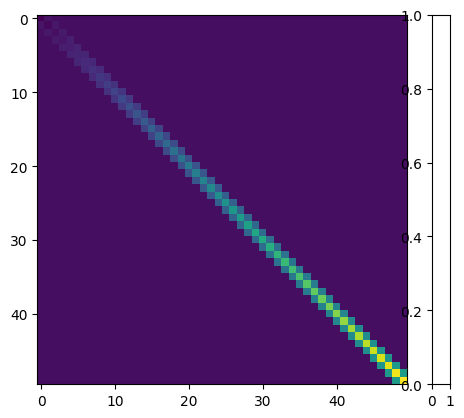

In [105]:
N = 50
l = 0
q = 0.7

r_min = 10**-13
r_max = 350
Nr = 10**5

# V = lambda r: V2(r, **ATOMS["Li"])
Vf = lambda r: V1(r)

H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble, Vf)

eigenvalues, eigenvectors = sp.linalg.eigh(H, B)

plt.imshow(H)
plt.colorbar()
plt.xticks(np.arange(0, N+1, 10), fontsize=20)
plt.yticks(np.arange(0, N+1, 10), fontsize=20)
plt.title("Hamiltonian", fontsize=30, pad=20)
plt.show()

In [138]:
N = 100
l = 0
q = 0.7

r_min = 10**-13
r_max = 350
Nr = 4*10**5

Vf = lambda r: V2(r, **ATOMS["Li"])
# Vf = lambda r: V1(r)

H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble, Vf)

eigenvalues, eigenvectors = sp.linalg.eigh(H, B)

H,B calculation for N=100, Nr=1000000


100%|██████████| 100/100 [03:59<00:00,  2.39s/it]


In [147]:
eigenvalues = np.array([-5.91302102e+02, -8.17975021e+01, -1.11654003e+01, -1.20452692e+00,
       -1.59071491e-01, -6.30889808e-02, -3.41518564e-02, -2.14258590e-02,
       -1.46957412e-02, -1.07052818e-02, -8.14525544e-03, -6.40508801e-03,
       -5.16854643e-03, -4.25843788e-03, -3.56918463e-03, -3.03469192e-03,
       -2.61186459e-03, -2.27162912e-03, -1.99379423e-03, -1.76398254e-03,
       -1.57173125e-03, -1.40927942e-03, -1.27077188e-03, -1.15172403e-03,
       -1.04865408e-03, -9.58825555e-04, -8.80063681e-04, -8.10622517e-04,
       -7.49087338e-04, -6.94301996e-04, -6.45314209e-04, -6.01333900e-04,
       -5.61701134e-04, -5.25861216e-04, -4.93345176e-04, -4.63754351e-04,
       -4.36748100e-04, -4.12033963e-04, -3.89359705e-04, -3.68506859e-04,
       -3.49285415e-04, -3.31528558e-04, -3.15070283e-04, -2.99579604e-04,
       -2.84150281e-04, -2.67579450e-04, -2.49325063e-04, -2.29412623e-04,
       -2.07983144e-04, -1.85156164e-04])

a = 0.999955823604574, b = -3.163106617816691 


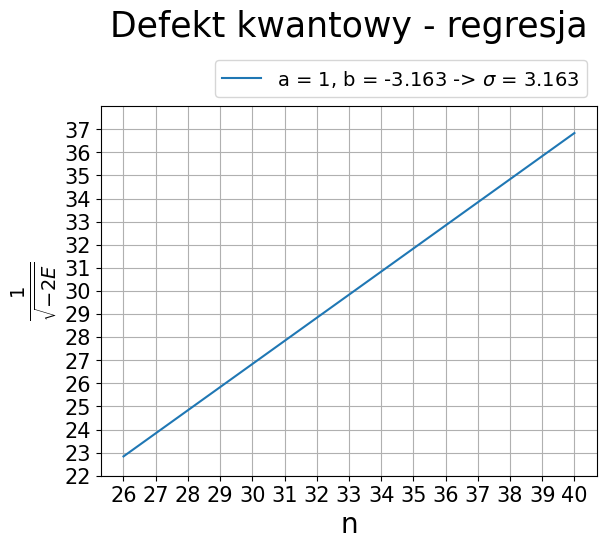

In [149]:

eig_start = 25
eig_end = 40

energies = eigenvalues[eig_start:eig_end]
n = np.arange(1, len(energies)+1)+eig_start
Et = 1/np.sqrt(-2*energies)

reg = sp.stats.linregress(n, Et)

plt.plot(n,Et, label=fr"a = {reg.slope:.4G}, b = {reg.intercept:.4G} -> $\sigma$ = {-reg.intercept:.4G}")
print(f"a = {reg.slope}, b = {reg.intercept} ")
plt.grid()
plt.xlabel("n", fontsize=20)
plt.ylabel(r"$\frac{1}{\sqrt{-2E}}$", fontsize=20)
plt.xticks(n, fontsize=15)
start = np.ceil(eig_start+reg.intercept)
end = np.ceil(eig_end+1+reg.intercept)
plt.yticks(np.arange(start, end, 1), fontsize=15)
plt.ylim(start, end)
plt.title("Defekt kwantowy - regresja", fontsize=25, pad=50)
plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.0, 1.15))
plt.show()

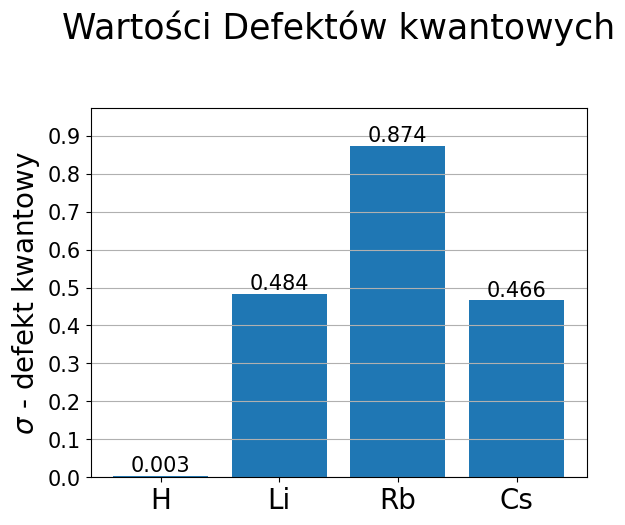

In [121]:
atoms_names = ["H", "Li", "Rb", "Cs"]
atoms_defects = [0.003, 0.484, 0.874, 0.466]

plt.bar_label(plt.bar(atoms_names, atoms_defects), fontsize=15)
plt.grid(axis="y")
plt.title("Wartości Defektów kwantowych", fontsize=25, pad=50)
plt.ylabel(r"$\sigma$ - defekt kwantowy", fontsize=20)
plt.locator_params(axis='y', nbins=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=20)
plt.ylim(0, max(atoms_defects)+0.1)
plt.show()

In [10]:
l = 0
q = 0.7

r_min = 10**-13
r_max = 4000
Nr = 10**4

N_list = np.linspace(30, 1250, 15).astype(int)
energies = np.zeros((N_list.max(),N_list.shape[0]))
energies.fill(np.nan)

for i, N in enumerate(N_list):
    H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble, V1)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies[:eigenvalues.shape[0], i] = eigenvalues
    except Exception as e:
        pass

energies = np.array(energies)

H,B calculation for N=30, Nr=10000


100%|██████████| 30/30 [00:00<00:00, 137.87it/s]


H,B calculation for N=117, Nr=10000


100%|██████████| 117/117 [00:03<00:00, 36.16it/s]


H,B calculation for N=204, Nr=10000


100%|██████████| 204/204 [00:09<00:00, 21.15it/s]


H,B calculation for N=291, Nr=10000


100%|██████████| 291/291 [00:19<00:00, 14.95it/s]


H,B calculation for N=378, Nr=10000


100%|██████████| 378/378 [00:32<00:00, 11.53it/s]


H,B calculation for N=465, Nr=10000


100%|██████████| 465/465 [00:49<00:00,  9.36it/s]


H,B calculation for N=552, Nr=10000


100%|██████████| 552/552 [01:10<00:00,  7.83it/s]


H,B calculation for N=640, Nr=10000


100%|██████████| 640/640 [01:34<00:00,  6.76it/s]


H,B calculation for N=727, Nr=10000


100%|██████████| 727/727 [02:02<00:00,  5.93it/s]


H,B calculation for N=814, Nr=10000


100%|██████████| 814/814 [02:29<00:00,  5.44it/s]


H,B calculation for N=901, Nr=10000


100%|██████████| 901/901 [03:04<00:00,  4.88it/s]


H,B calculation for N=988, Nr=10000


100%|██████████| 988/988 [03:45<00:00,  4.38it/s]


H,B calculation for N=1075, Nr=10000


100%|██████████| 1075/1075 [04:27<00:00,  4.03it/s]


H,B calculation for N=1162, Nr=10000


100%|██████████| 1162/1162 [05:07<00:00,  3.78it/s]


H,B calculation for N=1250, Nr=10000


100%|██████████| 1250/1250 [05:59<00:00,  3.47it/s]


In [18]:
np.save("energies.npy", energies)


In [21]:
np.save("nlist.npy", N_list)

In [26]:
energies = np.load("energies.npy")


([<matplotlib.axis.YTick at 0x7ff497e3eb90>,
 [Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$')])

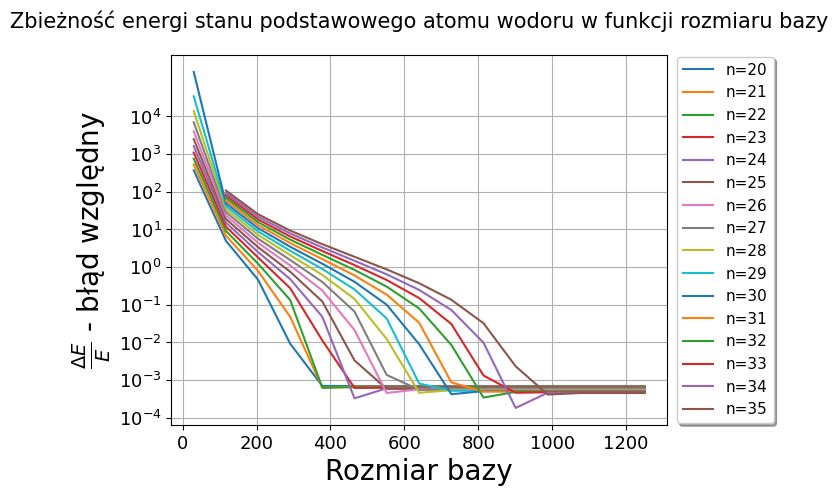

In [61]:
for i in range(19, 35):
    En = (-1/2 *(1/(i + 1)**2))
    plt.plot(N_list, np.abs(energies[i] - En)/np.abs(En), label=f"n={i+1}")
    plt.yscale("log")

plt.title(f"Zbieżność energi stanu podstawowego atomu wodoru w funkcji rozmiaru bazy", fontsize=15, pad=20)
plt.xlabel("Rozmiar bazy", fontsize=20)
plt.ylabel(r"$\frac{\Delta E}{E}$ - błąd względny", fontsize=20)
plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=11)
plt.grid()
plt.xticks(fontsize=13)
plt.yticks([10e-5,10e-4, 10e-3,10e-2,10e-1,10e0, 10e1, 10e2,10e3],fontsize=13)

H,B calculation for N=100, Nr=1


100%|██████████| 100/100 [00:00<00:00, 1336.12it/s]


H,B calculation for N=100, Nr=309


100%|██████████| 100/100 [00:00<00:00, 1149.63it/s]


H,B calculation for N=100, Nr=1168


100%|██████████| 100/100 [00:00<00:00, 824.55it/s]


H,B calculation for N=100, Nr=2578


100%|██████████| 100/100 [00:00<00:00, 641.74it/s]


H,B calculation for N=100, Nr=4538


100%|██████████| 100/100 [00:00<00:00, 478.90it/s]


H,B calculation for N=100, Nr=7048


100%|██████████| 100/100 [00:00<00:00, 375.63it/s]


H,B calculation for N=100, Nr=10109


100%|██████████| 100/100 [00:00<00:00, 283.02it/s]


H,B calculation for N=100, Nr=13721


100%|██████████| 100/100 [00:00<00:00, 226.67it/s]


H,B calculation for N=100, Nr=17883


100%|██████████| 100/100 [00:00<00:00, 178.58it/s]


H,B calculation for N=100, Nr=22596


100%|██████████| 100/100 [00:00<00:00, 147.06it/s]


H,B calculation for N=100, Nr=27859


100%|██████████| 100/100 [00:00<00:00, 117.88it/s]


H,B calculation for N=100, Nr=33672


100%|██████████| 100/100 [00:01<00:00, 82.70it/s]


H,B calculation for N=100, Nr=40036


100%|██████████| 100/100 [00:01<00:00, 65.40it/s]


H,B calculation for N=100, Nr=46951


100%|██████████| 100/100 [00:01<00:00, 53.68it/s]


H,B calculation for N=100, Nr=54416


100%|██████████| 100/100 [00:02<00:00, 46.86it/s]


H,B calculation for N=100, Nr=62432


100%|██████████| 100/100 [00:02<00:00, 37.22it/s]


H,B calculation for N=100, Nr=70998


100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


H,B calculation for N=100, Nr=80115


100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


H,B calculation for N=100, Nr=89782


100%|██████████| 100/100 [00:04<00:00, 23.63it/s]


H,B calculation for N=100, Nr=100000


100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


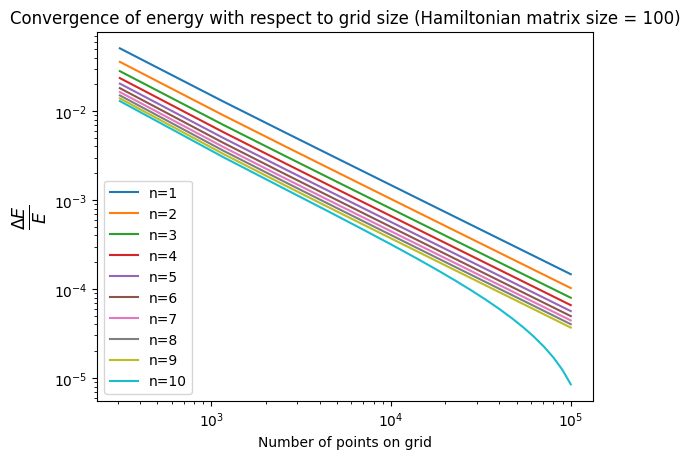

In [85]:
N = 100
l = 0
q = 0.7

r_min = 10**-13
r_max = 350

energies = []
Nr_list = np.linspace(np.sqrt(1.0), np.sqrt(100000), 20)
Nr_list = np.round(Nr_list**2).astype(int)

# Nr_list = [100, 120, 140, 160, 180, 200, 300, 400, 600, 1000, 2000, 5000, 9000, 10000, 11000, 30000, 100000, 500000, 1000000,]
for Nr in Nr_list:
    H, B = HB(N, l, q, r_min, r_max, Nr, np.float64, Vf)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies.append(np.array(eigenvalues))
    except Exception as e:
        energies.append(np.array([np.nan]*N))
energies = np.array(energies)

energies = energies.T

for i in range(10):
    En = (-1/2 *(1/(i + 1)**2))
    plt.plot(Nr_list, np.abs(energies[i] - En)/np.abs(En), label=f"n={i+1}")
    plt.xscale("log")
    plt.yscale("log")

plt.title(f"Convergence of energy with respect to grid size (Hamiltonian matrix size = {N})")
plt.xlabel("Number of points on grid")
plt.ylabel(r"$\frac{\Delta E}{E}$", fontsize=18)
plt.legend()